# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical,plot_model

from keras.models import Input,Model,Sequential
from keras.layers import LSTM,Embedding,Dropout,Activation,Reshape,Dense,GRU,Add,Flatten,concatenate

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences


# Dataset Preparation

In [2]:
data = pd.read_csv('/kaggle/input/data-combine/data_combined.csv')

In [10]:
data.head()

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [6]:
data['stance_cat'] = data['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
data['Stance'].value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

In [3]:
corpus = np.r_[data['Headline'].values,data['articleBody'].values]
print(49972*2)
print(len(corpus)) # first 49972 contains the Headline and next 49972 contains the articleBody

vocabulary = []
for sentence in corpus:
    vocabulary.extend(sentence.split(' '))

vocabulary = list(set(vocabulary))
vocab_length = len(vocabulary)
print("Vocabulary Length is {0}".format(vocab_length))


99944
99944
Vocabulary Length is 64510


In [4]:
max_features = 5000
max_nb_words = 24000
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH_HEADLINE = 64
MAX_SEQUENCE_LENGTH_BODY = 64

In [7]:

encoded_docs_headline = [one_hot(sentence,vocab_length) for sentence in data.loc[:,'Headline'].tolist()]
padded_docs_headline = pad_sequences(encoded_docs_headline,MAX_SEQUENCE_LENGTH_HEADLINE,padding='post')

encoded_docs_body = [one_hot(sentence,vocab_length) for sentence in data.loc[:,'articleBody'].tolist()]
padded_docs_body = pad_sequences(encoded_docs_body,MAX_SEQUENCE_LENGTH_BODY,padding='post')


labels = to_categorical(data.loc[:,'stance_cat'])


In [9]:
from keras.preprocessing.text import one_hot
one_hot("my name is kalyan",10)

[7, 1, 8, 7]

In [8]:
padded_docs_headline_train = padded_docs_headline[:int(len(padded_docs_headline)*0.8),:]
padded_docs_headline_test = padded_docs_headline[int(len(padded_docs_headline)*0.8):,:]

padded_docs_body_train = padded_docs_body[:int(len(padded_docs_body)*0.8),:]
padded_docs_body_test = padded_docs_body[int(len(padded_docs_body)*0.8):,:]

labels_train = labels[:int(len(labels)*0.8),:]
labels_test = labels[int(len(labels)*0.8):,:]


# Defining Model Architecture

In [11]:
input_headline = Input(shape=[64],name='input_headline')
embedding_headline = Embedding(vocab_length,50,input_length = MAX_SEQUENCE_LENGTH_HEADLINE)(input_headline)
# dense_headline = Dense(16,activation='relu')(embedding_headline)

input_body = Input(shape=[64],name='input_body')
embedding_body = Embedding(vocab_length,50,input_length = MAX_SEQUENCE_LENGTH_BODY)(input_body)
# dense_body = Dense(16,activation='relu')(embedding_body)

addition_layer = concatenate([embedding_headline,embedding_body])
lstm = LSTM(units=64)(addition_layer)
# drop = Dropout(0.25)(lstm)

# flatten = Flatten()(addition_layer)
output = Dense(4,activation='sigmoid')(lstm)

model_combined = Model(inputs=[input_headline,input_body],outputs=output)

model_combined.compile(optimizer = 'adam',loss ='categorical_crossentropy',metrics = ['accuracy'])


# Model Architecture

In [12]:
model_combined.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_headline (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_body (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 64, 50)       3225500     input_headline[0][0]             
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 64, 50)       3225500     input_body[0][0]                 
______________________________________________________________________________________________

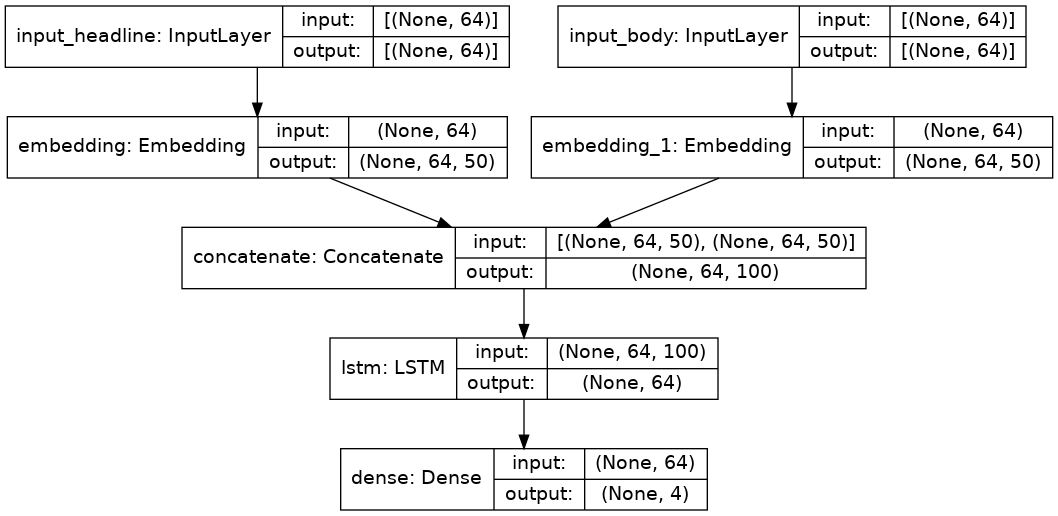

In [13]:
plot_model(model_combined, to_file='model_one_hot.png', show_shapes=True, show_layer_names=True)


# Model Training

In [14]:
model_combined.fit([padded_docs_headline_train,padded_docs_body_train],labels_train,epochs=15,verbose=1,validation_data=([padded_docs_headline_test,padded_docs_body_test],labels_test))

Epoch 1/15
1250/1250 [==============================] - 81s 61ms/step - loss: 0.7433 - accuracy: 0.7460 - val_loss: 0.5401 - val_accuracy: 0.8019
Epoch 2/15
1250/1250 [==============================] - 76s 61ms/step - loss: 0.5126 - accuracy: 0.8161 - val_loss: 0.4609 - val_accuracy: 0.8419
Epoch 3/15
1250/1250 [==============================] - 77s 62ms/step - loss: 0.4106 - accuracy: 0.8538 - val_loss: 0.4010 - val_accuracy: 0.8567
Epoch 4/15
1250/1250 [==============================] - 76s 61ms/step - loss: 0.3298 - accuracy: 0.8781 - val_loss: 0.3644 - val_accuracy: 0.8667
Epoch 5/15
1250/1250 [==============================] - 75s 60ms/step - loss: 0.2839 - accuracy: 0.8924 - val_loss: 0.3489 - val_accuracy: 0.8722
Epoch 6/15
1250/1250 [==============================] - 76s 61ms/step - loss: 0.2384 - accuracy: 0.9086 - val_loss: 0.3221 - val_accuracy: 0.8854
Epoch 7/15
1250/1250 [==============================] - 76s 60ms/step - loss: 0.2000 - accuracy: 0.9234 - val_loss: 0.3256 -

In [15]:
model_combined.save("one.h5")

In [10]:
txth1="Op-Ed: Hoax – Priest who never existed claims he died, saw female God"

txtb1="A catholic priest from Masschussetts, who was reported dead for close to an hour before medics were able to revive him, has made a shocking revelation upon his return to life. The 71-years old priest, identified as, Father John Micheal O’neal, claims he went to heaven and met God, whom he describes as a warm and comforting motherly figure. ‘Her presence was both overwhelming and comforting, she had a soft and soothing voice and her presence was as reassuring as a mother’s embrace. ‘The fact that God is a Holy Mother instead of a Holy Father doesn’t disturb me, she is everything I hoped she would be and even more!’ Despite the shocking revelation, which is being received with a bit of confusion in the Catholic world, Father O’neal says he still wishes to continue dedicating his life to God and spread the word of the ‘Holy Mother’. ‘I wish to continue preaching. I would like to share my new knowledge of the Mother, the Son and the Holy Ghost with all Catholics and even all Christians. God is great and almighty despite being a woman,’ he said. With his new outlook, the Roman Catholic Archdiocese of Boston is yet to confirm if Father O’neal will be permitted to resume preaching in his former parish in South Boston or not. Father John Micheal O’neal, who was rushed to Massachusetts General Hospital on Thursday, January 29, 2015, was revived through the aid of a high-tech machine called LUCAS 2, which kept the blood flowing to his brain as doctors managed to unblock vital arteries and return his heart to a normal rhythm, after a major heart attack"

In [9]:
import keras
mdl=keras.models.load_model("/kaggle/input/models/one.h5")

In [11]:
test_headline, test_body = txth1, txtb1
encoded_test_headline = [one_hot(test_headline, vocab_length)]
padded_test_headline = pad_sequences(encoded_test_headline,MAX_SEQUENCE_LENGTH_HEADLINE,padding='post')

encoded_test_body = [one_hot(test_body, vocab_length)]
padded_test_body = pad_sequences(encoded_test_body,MAX_SEQUENCE_LENGTH_BODY,padding='post')

In [12]:
mdl.predict([padded_test_headline,padded_test_body])

array([[0.93104374, 0.9285259 , 0.04661772, 0.39792207]], dtype=float32)

In [24]:
txth3="Star Wars 7: JJ Abrams want to move release to summer 2015"
txtb3="In quite recent news, J J Abrams has reportedly said at the Visual Effects Society Awards (2015) that he may release his extremely anticipated film, Star Wars: Episode VII — The Force Awakens. instead of winter he may move his film down the line for a summer release! This is an extremely brave move (if true) as it puts Star Wars up against films like Avengers 2: Age Of Ultron, Ant-Man and the long awaited Jurassic World but who would win at the summer box office if it were to happen? In my opinion Star Wars has got the strongest chance at the box office if moved to a summer release but why would he do it? All the big films come out in the summer and I mean there's no Hobbit to compete with in December so why move it down to Summer?Box office championship.Box office championship.J J's biggest reason was reported to be that all of the Star Wars plot leaks and pictures of characters had sent him on a little scare that more and more would be leaked therefore making the film predictable and not worth watching. For example just one photo can give away a lot for instance: (If you don't want spoilers look away!)Sorry J J!Sorry J J!For instance these 5 figures reveal the character's Kylo Ren, Rey, Fin, BB-8 and shows us what Kylo Ren (ol' crossguard) will look like with his outer cloak removed. I do see that if more of these pictures are leaked we could be seeing what Han, Leia, Luke, C3PO etc. will be like in the film before seeing a company made trailer, which would ruin the surprise. Disney, being the owners of the new Star Wars franchise, have taken J J's thoughts into consideration and deep thought which could get the film released a lot earlier than we thought we were going to see it! There are some bad things about this though... If we do get what we all wish for and we get to see Star Wars 7 about 6 months before we thought we were going to, won't Disney be in a panic? If they thought that their blockbuster was coming in December would they have ordered toy designs, trailers etc. for later on in the year? Perhaps this is just paranoia but Disney and J J will have a lot of work to get done if they want their merchandise etc. to come alongside Star Wars in summer.I gathered the basis of this information from Votesaxon07 (part of following the nerd) who's a great youtuber and if you want to see the information for yourself watch this video which also has news for Frozen fever, the A.T.O.M suit, Deadpool movie news and other awesome snip-its:Thanks for reading guys and I hope you gained some information from this and enjoyed reading through some of my opinions on the topic! (Thanks to Votesaxon07 and following the nerd for the awesome news!)"

In [26]:
txth2="Op-Ed: Hoax – Priest who never existed claims he died, saw female God"
txtb2="A catholic priest from Masschussetts, who was reported dead for close to an hour before medics were able to revive him, has made a shocking revelation upon his return to life. The 71-years old priest, identified as, Father John Micheal O’neal, claims he went to heaven and met God, whom he describes as a warm and comforting motherly figure. ‘Her presence was both overwhelming and comforting, she had a soft and soothing voice and her presence was as reassuring as a mother’s embrace. ‘The fact that God is a Holy Mother instead of a Holy Father doesn’t disturb me, she is everything I hoped she would be and even more!’ Despite the shocking revelation, which is being received with a bit of confusion in the Catholic world, Father O’neal says he still wishes to continue dedicating his life to God and spread the word of the ‘Holy Mother’. ‘I wish to continue preaching. I would like to share my new knowledge of the Mother, the Son and the Holy Ghost with all Catholics and even all Christians. God is great and almighty despite being a woman,’ he said. With his new outlook, the Roman Catholic Archdiocese of Boston is yet to confirm if Father O’neal will be permitted to resume preaching in his former parish in South Boston or not. Father John Micheal O’neal, who was rushed to Massachusetts General Hospital on Thursday, January 29, 2015, was revived through the aid of a high-tech machine called LUCAS 2, which kept the blood flowing to his brain as doctors managed to unblock vital arteries and return his heart to a normal rhythm, after a major heart attack. ..."

**Please upvote the notebook if you find it useful**

In [27]:
txth4="Meteorite makes big crater in Nicaragua, government says"
txtb4="A catholic priest from Masschussetts, who was reported dead for close to an hour before medics were able to revive him, has made a shocking revelation upon his return to life. The 71-years old priest, identified as, Father John Micheal O’neal, claims he went to heaven and met God, whom he describes as a warm and comforting motherly figure. ‘Her presence was both overwhelming and comforting, she had a soft and soothing voice and her presence was as reassuring as a mother’s embrace. ‘The fact that God is a Holy Mother instead of a Holy Father doesn’t disturb me, she is everything I hoped she would be and even more!’ Despite the shocking revelation, which is being received with a bit of confusion in the Catholic world, Father O’neal says he still wishes to continue dedicating his life to God and spread the word of the ‘Holy Mother’. ‘I wish to continue preaching. I would like to share my new knowledge of the Mother, the Son and the Holy Ghost with all Catholics and even all Christians. God is great and almighty despite being a woman,’ he said. With his new outlook, the Roman Catholic Archdiocese of Boston is yet to confirm if Father O’neal will be permitted to resume preaching in his former parish in South Boston or not. Father John Micheal O’neal, who was rushed to Massachusetts General Hospital on Thursday, January 29, 2015, was revived through the aid of a high-tech machine called LUCAS 2, which kept the blood flowing to his brain as doctors managed to unblock vital arteries and return his heart to a normal rhythm, after a major heart attack. ..."

In [28]:
txth1="Video: Marine survives Taliban sniper headshot thanks to helme"
txtb1="A video of a US marine surviving being shot in the head by a sniper in Afghanistan in 2013 is being shared across the internet.The description on the YouTube clip claims the incident took place during a raid in the Now Zad district of Helmand Province.The video shows the marine being struck on the helmet by an unseen sniper during the raid.Afterwards the US serviceman tells his colleagues he is fine, other than a ringing in his ears.The video was uploaded on 26 September by Sam Arnold, who has been described as an Afghanistan veteran.BuzzFeed News has contact Arnold for a comment on his incredible video."

In [29]:
test_headline, test_body = txth1, txtb1
encoded_test_headline = [one_hot(test_headline, vocab_length)]
padded_test_headline = pad_sequences(encoded_test_headline,MAX_SEQUENCE_LENGTH_HEADLINE,padding='post')

encoded_test_body = [one_hot(test_body, vocab_length)]
padded_test_body = pad_sequences(encoded_test_body,MAX_SEQUENCE_LENGTH_BODY,padding='post')

mdl.predict([padded_test_headline,padded_test_body])

array([[0.99437547, 0.9821162 , 0.18365197, 0.02054605]], dtype=float32)

In [30]:
test_headline, test_body = txth2, txtb2
encoded_test_headline = [one_hot(test_headline, vocab_length)]
padded_test_headline = pad_sequences(encoded_test_headline,MAX_SEQUENCE_LENGTH_HEADLINE,padding='post')

encoded_test_body = [one_hot(test_body, vocab_length)]
padded_test_body = pad_sequences(encoded_test_body,MAX_SEQUENCE_LENGTH_BODY,padding='post')

mdl.predict([padded_test_headline,padded_test_body])

array([[0.93104374, 0.9285259 , 0.04661772, 0.39792207]], dtype=float32)

In [31]:
test_headline, test_body = txth3, txtb3
encoded_test_headline = [one_hot(test_headline, vocab_length)]
padded_test_headline = pad_sequences(encoded_test_headline,MAX_SEQUENCE_LENGTH_HEADLINE,padding='post')

encoded_test_body = [one_hot(test_body, vocab_length)]
padded_test_body = pad_sequences(encoded_test_body,MAX_SEQUENCE_LENGTH_BODY,padding='post')

mdl.predict([padded_test_headline,padded_test_body])

array([[0.08497232, 0.10717534, 0.07188159, 0.9880514 ]], dtype=float32)

In [32]:
test_headline, test_body = txth4, txtb4
encoded_test_headline = [one_hot(test_headline, vocab_length)]
padded_test_headline = pad_sequences(encoded_test_headline,MAX_SEQUENCE_LENGTH_HEADLINE,padding='post')

encoded_test_body = [one_hot(test_body, vocab_length)]
padded_test_body = pad_sequences(encoded_test_body,MAX_SEQUENCE_LENGTH_BODY,padding='post')

mdl.predict([padded_test_headline,padded_test_body])

array([[0.4914837 , 0.5469607 , 0.23268123, 0.6882632 ]], dtype=float32)